# Growing Neural Cellular Automata (the stripped-down version)

This notebook contains a minimal version of the [code](https://github.com/google-research/self-organising-systems/blob/master/notebooks/growing_ca.ipynb) related to the Distill article on [Growing Neural Cellular Automata](https://distill.pub/2020/growing-ca/).

The code is simplified, and so is the setting (for quicker training and experimentation.)

Why include this code? To give a quick overview of the crucial parts of the system that will then make it easier to understand the successive application of NCAs to image classification.

In [1]:
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import requests
import numpy as np
import matplotlib.pylab as pl

import tensorflow as tf
from tensorflow.keras.layers import Conv2D

from IPython.display import Image, clear_output

In [2]:
clear_output()

## Image manipulation utilities

In [3]:
def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)

  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))

  th, tw = a.shape[1:3]
  pad = (w - len(a)) % w
  a = np.pad(a, [(0, pad)] + [(0, 0)] * (a.ndim - 1), 'constant')
  h = len(a) // w

  a = a.reshape([h, w] + list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th * h, tw * w])
  return a

def load_image(url, max_size):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.LANCZOS)
  # convert image to grayscale (RGB is not essential and slows down training)
  img = img.convert('L')
  img = np.float32(img) / 255.0
  return img

def load_emoji(emoji, max_size):
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true' % code
  return load_image(url, max_size)

# adds an alpha channel to the original grayscale image (determines "liveness")
def add_alpha(x):
  # adding a dummy alpha channel with full opacity
  alpha_channel = np.ones_like(x)[..., None]
  return np.concatenate([x[..., None], alpha_channel], axis=-1)

# return only the first two channels (grayscale and alpha)
def to_la(x):
  return x[..., :2]

def to_alpha(x):
  return tf.clip_by_value(x[..., 1:2], 0.0, 1.0)

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

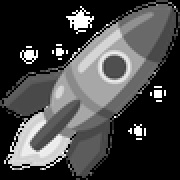

In [4]:
# let's check that everything works as expected... (you might want to change max_size at training time...)
emoji = "🚀" # insert your favourite emoji here
img = load_emoji(emoji, max_size=90)
imshow(zoom(img, 2))

## Model definition and hypeparameters

In [6]:
CHANNEL_N = 10 # number of CA state channels
TARGET_PADDING = 12 # number of pixels used to pad the target image border
TARGET_SIZE = 10
BATCH_SIZE = 8
POOL_SIZE = 128
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🔴"

Let's define some utilities.

In [7]:
# check if the cell is alive
def get_living_mask(x):
  alpha = x[:, :, :, 1:2]
  return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1

In [8]:
class CAModel(tf.keras.Model):
  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    self.dmodel = tf.keras.Sequential([
          Conv2D(128, 1, activation=tf.nn.relu),
          Conv2D(self.channel_n, 1, activation=None,
              kernel_initializer=tf.zeros_initializer),
    ])

    self(tf.zeros([1, 3, 3, channel_n])) # dummy call to build the model

  @tf.function
  def perceive(self, x, angle=0.0):
    identify = np.float32([0, 1, 0])
    identify = np.outer(identify, identify)
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0 # Sobel filter
    dy = dx.T
    c, s = tf.cos(angle), tf.sin(angle)
    kernel = tf.stack([identify, c*dx-s*dy, s*dx+c*dy], -1)[:, :, None, :]
    kernel = tf.repeat(kernel, self.channel_n, 2)

    y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
    return y

  @tf.function
  def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    pre_life_mask = get_living_mask(x)

    y = self.perceive(x, angle)
    dx = self.dmodel(y)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
    x += dx * tf.cast(update_mask, tf.float32)

    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    return x * tf.cast(life_mask, tf.float32)

In [9]:
CAModel().dmodel.summary()

2023-08-13 15:28:24.396056: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-08-13 15:28:24.396075: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-13 15:28:24.396083: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-13 15:28:24.396113: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-13 15:28:24.396130: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (1, 3, 3, 128)            3968      
                                                                 
 conv2d_1 (Conv2D)           (1, 3, 3, 10)             1290      
                                                                 
Total params: 5258 (20.54 KB)
Trainable params: 5258 (20.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-08-13 15:28:24.633276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


## Training

### Preparation code.

In [10]:
class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.asarray(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

In [11]:
def generate_pool_figures(pool, step_i):
  tiled_pool = tile2d(pool.x[:49, :, :, :1])
  ones = np.ones(72)
  tiled_pool[:, :72] += (-tiled_pool[:, :72] + ones[None, :])
  tiled_pool[:, -72:] += (-tiled_pool[:, -72:] + ones[None, :])
  tiled_pool[:72, :] += (-tiled_pool[:72, :] + ones[:, None])
  tiled_pool[-72:, :] += (-tiled_pool[-72:, :] + ones[:, None])
  imwrite('train_log/%04d_pool.jpg' % step_i, tiled_pool)

def visualize_batch(x0, x, step_i):
  vis0 = np.hstack(x0[..., :1])
  vis1 = np.hstack(x[..., :1])
  vis = np.vstack([vis0, vis1])
  vis = np.squeeze(vis, axis=-1) # for imwrite and imshow
  imwrite('train_log/batches_%04d.jpg' % step_i, vis)
  print('batch (before/after):')
  imshow(vis)

def loss_f(x, target):
  return tf.reduce_mean(tf.square(to_la(x) - target), [-2, -3, -1])

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.5)
  pl.show()

In [12]:
target_img = add_alpha(load_emoji(TARGET_EMOJI, max_size=TARGET_SIZE))
imshow(zoom(target_img, 2), fmt='png')

In [13]:
p = TARGET_PADDING
pad_target = tf.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]

seed = np.zeros([h, w, CHANNEL_N], np.float32)
seed[h // 2, w // 2, 0] = 1.0  # for the grayscale channel
seed[h // 2, w // 2, 1:] = 1.0

Let's instantiate our model and loss and wrap up the preparations!

In [14]:
ca = CAModel()

loss_log = []

lr = 2e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr, lr*0.1])
trainer = tf.keras.optimizers.legacy.RMSprop(lr_sched)

loss0 = loss_f(seed, pad_target).numpy()
pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))

2023-08-13 15:28:25.115214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [15]:
!mkdir -p train_log && rm -f train_log/*

### Carry out training.

batch (before/after):


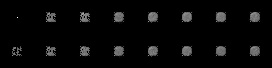

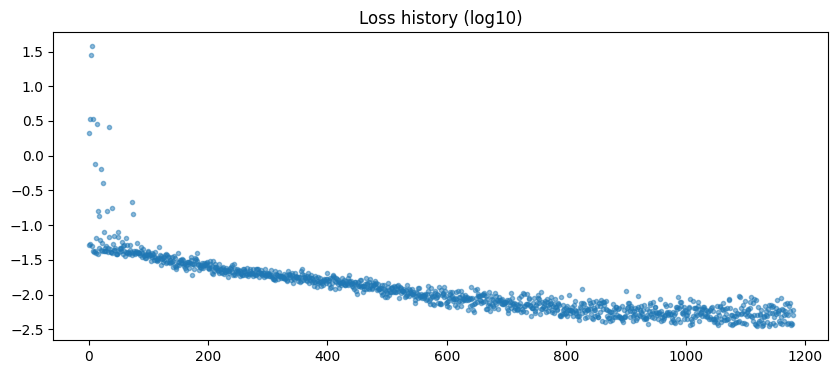

 step: 1190, log10(loss): -2.374

KeyboardInterrupt: 

In [16]:
@tf.function
def train_step(x):
  iter_n = tf.random.uniform([], 64, 96, tf.int32)
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x = ca(x)
    loss = tf.reduce_mean(loss_f(x, pad_target))
  grads = g.gradient(loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, loss

for i in range(8000+1):
  batch = pool.sample(BATCH_SIZE)
  x0 = batch.x
  loss_rank = loss_f(x0, pad_target).numpy().argsort()[::-1]
  x0 = x0[loss_rank]
  x0[:1] = seed

  x, loss = train_step(x0)

  batch.x[:] = x
  batch.commit()

  step_i = len(loss_log)
  loss_log.append(loss.numpy())
  
  if step_i % 10 == 0:
    generate_pool_figures(pool, step_i)

  if step_i % 10 == 0:
    clear_output()
    visualize_batch(x0, x, step_i)
    plot_loss(loss_log)

  print('\r step: %d, log10(loss): %.3f' % (len(loss_log), np.log10(loss)), end='')